# The Deep Learning Model

Version Control:
- Basic: the simple and pure LSTM model
- Test: finding best epoch number
- Combination: combination of LSTM and AR model

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle

In [2]:
# import data
df = pd.read_csv("JointData.csv", index_col = False)
# df.set_index(pd.DatetimeIndex(df["date"]), inplace=True)  # make index with date
df = df[["date","cases"]]  # use only daily increment of cases to forcast
df.reset_index(drop=True, inplace=True)

In [3]:
# smoothing by taking average of 7 days(inclusive)
cases_ave = []
for i in range(6,len(df)):
    # remove day of week effect
    temp = np.mean(df.cases.iloc[i-6:i+1])  # 6 previous days and the exact date, 7 days' average
    cases_ave.append(temp)

df = df.iloc[6:].reset_index(drop = True)  # start on day 7, update index
df['case'] = cases_ave

In [4]:
# work with time series:

# smoothed
df1 = df[["date", "case"]]
# df1["date"] = pd.to_datetime(df1["date"])  # convert to datatime
df1.set_index("date", inplace=True)
df1 = df1.to_dict()['case']  # convert to dict in order to convert to series
s = pd.Series(df1)

# original
'''df2 = df[["date", "cases"]]
df2.set_index("date", inplace=True)
df2 = df2.to_dict()['cases']  # convert to dict in order to convert to series
t = pd.Series(df2)'''

## Long Short-Term Memory(LSTM)
- The Long Short-Term Memory network or LSTM is a recurrent neural network that can learn and forecast long sequences.
- Walk forward model validation: a prediction will be made for a time step, then the real value used for model to predict next time step
    - stimulates the reality
- RMSE will be used: punishes large errors and results in a score that is in the same units as the forecast data

In [5]:
# given historical observations (t-1, t-2, … t-n) forecast t and t+1(future 2 days)
n_lag = 7  # use 7 past days
n_seq = 2  # predict 2 future days
n_train = 21  # train set size
n_test = 18 # test set size

### Differencing
- Differencing of time series in discrete time
- transformation of series to a new time series wehre values are the difference between consecutive values of previous series
- help stablizing the mean of time series by removing trend

In [6]:
# create a differenced series
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [7]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    raw_values = raw_values.reshape(len(raw_values), 1)
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[-(n_train+n_test):-n_test], supervised_values[-n_test:]
    return scaler, train, test

In [8]:
# prepare data
scaler, train, test = prepare_data(s, n_test, n_lag, n_seq)  # smoothed

In [9]:
# scaler_o, train_o, test_o = prepare_data(t, n_test, n_lag, n_seq)  # original

In [10]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = keras.Sequential()
    model.add(layers.LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(layers.Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [11]:
# fit model
model = fit_lstm(train, n_lag, n_seq, 1, 100, 1)  # on smoothed

In [12]:
# model_o = fit_lstm(train_o, n_lag, n_seq, 1, 100, 1)  # on original

## Prediction and Evaluation

In [13]:
# make one forecast with an LSTM
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

In [14]:
# evaluate the model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [15]:
# make forecasts
forecasts = make_forecasts(model, 1, train, test, n_lag, n_seq)  # on smoothed

In [16]:
# make forecasts
# forecasts_o = make_forecasts(model_o, 1, train_o, test_o, n_lag, n_seq)  # on original

In [17]:
# invert differenced forecast
# transform back to original scale
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

In [18]:
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

In [19]:
# inverse transform forecasts and test
forecasts = inverse_transform(s, forecasts, scaler, n_test+2)  # on smoothed

In [20]:
# inverse transform forecasts and test
# forecasts_o = inverse_transform(t, forecasts_o, scaler, n_test+2)  # on original

In [21]:
# evaluate RMSE for each step in forcasting
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

In [22]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()

In [23]:
# evaluate forecasts
actual = [row[n_lag:] for row in test]
actual = inverse_transform(s, actual, scaler, n_test+2)
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

t+1 RMSE: 44.095570
t+2 RMSE: 56.870982


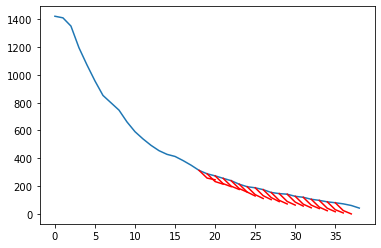

In [24]:
# plot forecasts
plot_forecasts(s[-(n_train+n_test):], forecasts, n_test+2)

In [25]:
# evaluate forecasts on original
'''actual_o = [row[n_lag:] for row in test_o]
actual_o = inverse_transform(t, actual_o, scaler_o, n_test+2)
evaluate_forecasts(actual_o, forecasts_o, n_lag, n_seq)'''

t+1 RMSE: 66.110297
t+2 RMSE: 101.886600


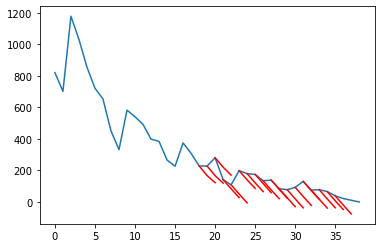

In [26]:
# plot forecasts on original
# plot_forecasts(t[-(n_train+n_test):], forecasts_o, n_test+2)

In [27]:
# save model to disk
'''filename = 'lstm_smooth.sav'
pickle.dump(model, open(filename, 'wb'))'''

"filename = 'lstm_smooth.sav'\npickle.dump(model, open(filename, 'wb'))"